### Librerias

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

### Parámetros

In [60]:
# Parámetros de LoRa
SF = 7                     # Spreading Factor
BW = 125e3                 # Bandwidth en Hz (125 kHz)
Fs = 1e6                   # Frecuencia de muestreo (1 MHz)
T_symbol = 2**SF / BW     # Duración de un símbolo
N = 2**SF                  # Número de muestras por símbolo (128)
Ts = T_symbol / N         # Período de muestreo efectivo

# Tiempo y muestras
Ts = 1 / BW               # Duración de cada chip
T_symbol = N * Ts         # Duración de un símbolo

t = np.linspace(0, T_symbol, N, endpoint=False)  # Vector de tiempo


### Generador de hipotesis 

In [61]:
#k indica la cantidad de vectores a generar
def generate_lora_bits(k):
    bits_totales = k * SF            # Número de símbolos a generar
    info_bits = np.zeros((bits_totales, SF),dtype=int)  # Matriz para almacenar los bits de información

    for i in range(bits_totales):
        for j in range(SF):
            info_bits[i, j] = np.random.randint(0, 2)
    
    return info_bits

### Encoder

In [62]:
def encode_lora_symbol(k):
    bits = generate_lora_bits(k)  # Generar k símbolos de LoRa
    simbolos = np.zeros((k, 1),dtype=int)  # Matriz para almacenar los símbolos
    for i in range(k):
        print("Bits:", bits[i])
        for j in range(SF):
            simbolos[i] += bits[i, SF - j - 1] * (2 ** j)  # recorremos de derecha a izquierda
            
        print("Valor decimal:", simbolos[i,0])
    return simbolos

### Decoder


In [63]:
def decoder(simbolos):
    bits = np.zeros((len(simbolos), SF), dtype=int)

    for i, simbolo in enumerate(simbolos):
        valor = simbolo[0] if isinstance(simbolo, np.ndarray) else simbolo
        bin_str = format(valor, f'0{SF}b')  # convierte a binario, con ceros a la izquierda
        bits[i] = [int(b) for b in bin_str]   # guarda como vector de bits
        print("Simbolo:", simbolo, "Bits decodificados:", bits[i])
        

    return bits

### Cálculo del ber

In [64]:
def calcular_ber(bits_enviados, bits_recibidos):
    errores = 0    
    for i in range(len(bits_enviados)):
        errores = errores + np.array_equal(bits_enviados[i], bits_recibidos[i])

    total_bits = bits_enviados.size
    ber = errores / total_bits

    return errores, total_bits, ber


### Waveform former

In [65]:
def waveform_lora(symbol):
    
    k = np.arange(N)
    fase = 2 * np.pi * ((symbol + k) % N) * k * Ts * BW / N
    wave = np.exp(1j * fase) / np.sqrt(N)
    return wave

### n-tupler 

In [66]:
def n_tupler(wave):
    # Paso 1: Dechirping
    k = np.arange(N)
    down_chirp = np.exp(-1j * 2 * np.pi * k**2 / N)
    d = wave * down_chirp

    # Paso 2: DFT (usando FFT) con fftshift
    spectrum = np.abs(np.fft.fft(d, n=N)) / np.sqrt(N)  # Normalización
    spectrum_shifted = np.fft.fftshift(spectrum)  # Reordenar frecuencias

    # Detectar símbolo
    detected_symbol = np.argmax(spectrum_shifted)
    simbolo = (detected_symbol - N//2) % N  # Mapear al símbolo LoRa
    
    print(f"Símbolo detectado: {simbolo}")
    return simbolo
    

### Ploteo

In [67]:
# === Ploteo ===

def ploteo(signal, symbol):

    plt.figure(figsize=(10, 5))

    # Señal en el tiempo
    plt.subplot(2, 1, 1)
    plt.plot(t * 1e3, np.real(signal), label='Parte Real')
    plt.title(f"Forma de onda LoRa (SF={SF}, símbolo={symbol})")
    plt.xlabel("Tiempo [ms]")
    plt.ylabel("Amplitud")



    # Calcular frecuencia instantánea
    # Derivada de la fase en el tiempo
    inst_phase = np.unwrap(np.angle(signal))
    inst_freq = np.diff(inst_phase) * Fs / (2 * np.pi)  # Hz
    t_mid = (t[:-1] + t[1:]) / 2  # Para alinear el tiempo con derivada

    # Ploteo
    plt.subplot(2, 1, 2)
    plt.plot(t_mid * 1e3, inst_freq / 1e3)
    plt.title(f"Frecuencia Instantánea del Chirp LoRa (símbolo={symbol}, SF={SF})")
    plt.xlabel("Tiempo [ms]")
    plt.ylabel("Frecuencia [kHz]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

## Simulación

Bits: [1 1 0 1 1 1 1]
Valor decimal: 111
Bits: [1 0 1 0 1 0 1]
Valor decimal: 85
Bits: [1 1 0 1 0 0 1]
Valor decimal: 105
Bits: [1 1 0 0 0 1 1]
Valor decimal: 99
Bits: [1 0 0 1 1 1 0]
Valor decimal: 78
Bits: [1 1 0 0 1 1 1]
Valor decimal: 103
Bits: [1 0 1 0 1 0 1]
Valor decimal: 85
Bits: [0 1 0 1 1 0 0]
Valor decimal: 44
Bits: [0 0 1 0 0 1 0]
Valor decimal: 18
Bits: [1 1 0 1 1 1 1]
Valor decimal: 111
Bits: [0 1 0 1 0 1 0]
Valor decimal: 42
Bits: [0 1 0 0 0 1 1]
Valor decimal: 35
Bits: [0 1 0 1 1 0 0]
Valor decimal: 44
Bits: [1 1 0 1 0 1 1]
Valor decimal: 107
Bits: [1 0 1 1 0 1 0]
Valor decimal: 90
Bits: [1 0 1 1 1 1 1]
Valor decimal: 95
Bits: [0 0 0 1 1 0 1]
Valor decimal: 13
Bits: [1 0 1 1 0 1 1]
Valor decimal: 91
Bits: [1 1 0 0 1 1 0]
Valor decimal: 102
Bits: [0 1 0 1 0 0 1]
Valor decimal: 41
Bits: [0 0 0 0 1 1 0]
Valor decimal: 6
Bits: [0 0 0 1 1 0 0]
Valor decimal: 12
Bits: [1 1 1 0 0 1 0]
Valor decimal: 114
Bits: [1 1 1 0 1 0 0]
Valor decimal: 116
Bits: [0 1 0 0 0 1 1]
Valor decim

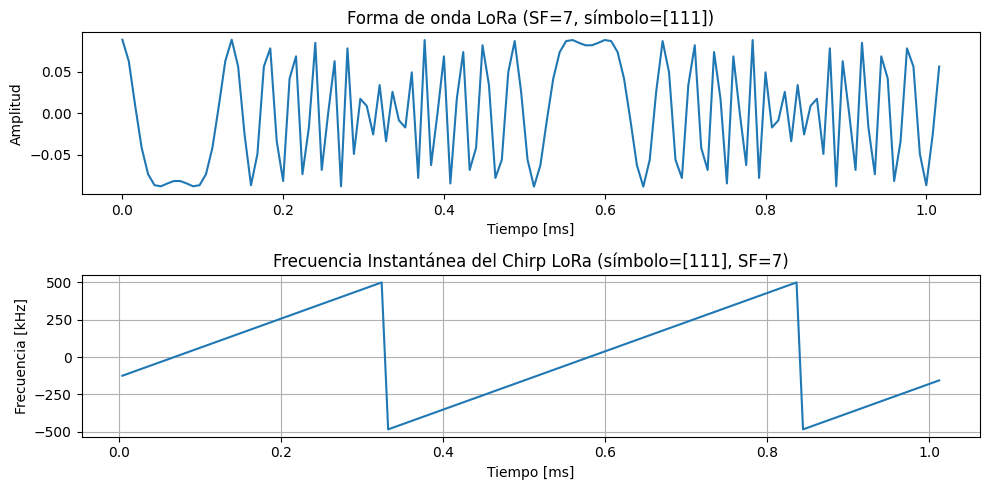

<Figure size 640x480 with 0 Axes>

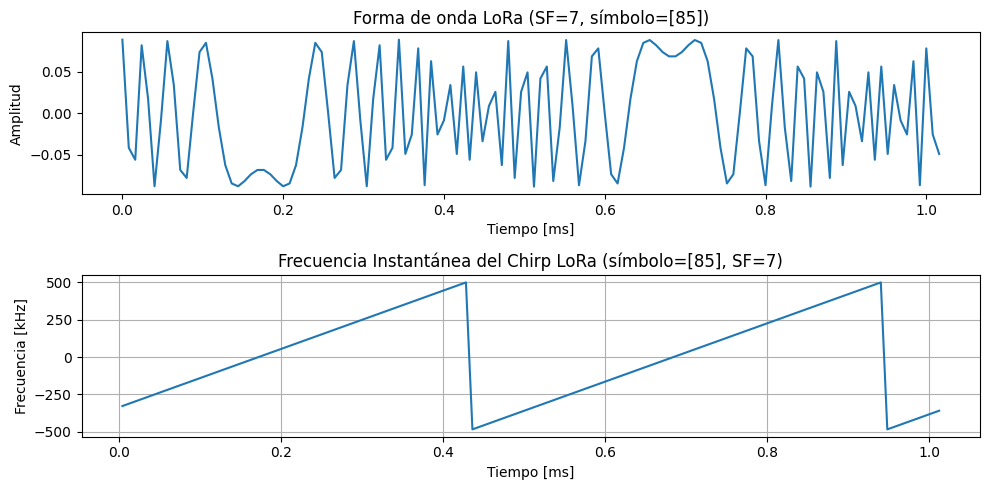

<Figure size 640x480 with 0 Axes>

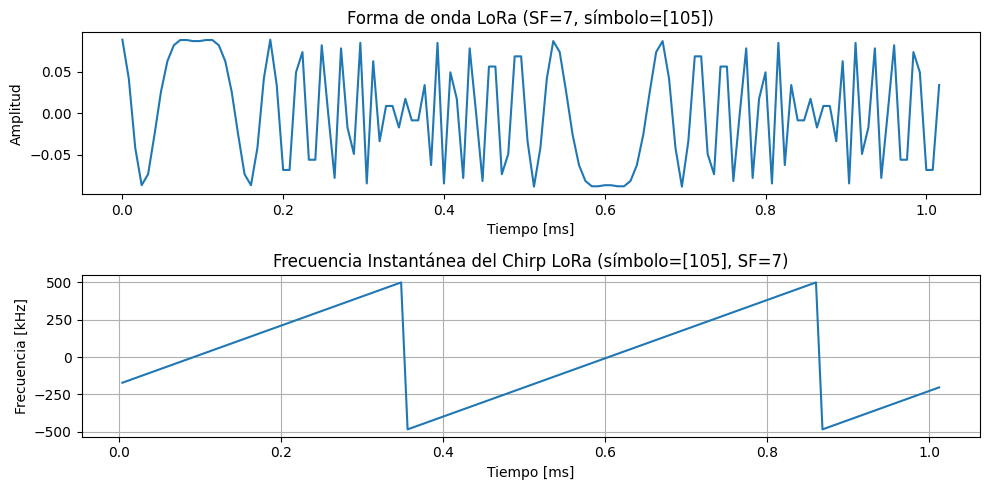

<Figure size 640x480 with 0 Axes>

In [70]:
info_enviada = encode_lora_symbol(5000)
info_recibida = decoder(info_enviada)
# Calcular BER
errores, total_bits, ber = calcular_ber(info_enviada, info_recibida)
print(f"Errores: {errores}, Total de cadena de bits: {total_bits}, BER: {ber:.4f}")

wave1 = waveform_lora(info_enviada[0])
simbolo1 = n_tupler(wave1)
wave2 = waveform_lora(info_enviada[1])
simbolo2 = n_tupler(wave2)
wave3 = waveform_lora(info_enviada[2])
simbolo3 = n_tupler(wave3)

ploteo(wave1, info_enviada[0])
ploteo(wave2, info_enviada[1])
ploteo(wave3, info_enviada[2])




